In [1]:
import sys
sys.path.append('../')
import pandas as pd 
import numpy as np 
import ta
from backtester import *

In [2]:
data = pd.read_csv('../forex_prices/m5/EUR_USD_m5.csv', index_col=['date'], parse_dates=['date'])
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-21 12:35:00,1.17674,1.17632,1.17677,1.17626,1.17686,1.17645,1.17688,1.17638,878,1.176800,1.176825,1.176320,1.176385
2021-07-21 12:40:00,1.17632,1.17625,1.17646,1.17614,1.17645,1.17638,1.17658,1.17625,1104,1.176385,1.176520,1.176195,1.176315
2021-07-21 12:45:00,1.17625,1.17594,1.17625,1.17594,1.17638,1.17606,1.17638,1.17606,1328,1.176315,1.176315,1.176000,1.176000
2021-07-21 12:50:00,1.17594,1.17637,1.17672,1.17591,1.17606,1.17650,1.17685,1.17603,1301,1.176000,1.176785,1.175970,1.176435
2021-07-21 12:55:00,1.17637,1.17654,1.17663,1.17614,1.17650,1.17667,1.17675,1.17626,1311,1.176435,1.176690,1.176200,1.176605


(10000, 13)


In [3]:
aroon = ta.trend.AroonIndicator(close=data['close'], window=25, fillna=False)

In [4]:
data['aroon_up'] = aroon.aroon_up()
data['aroon_down'] = aroon.aroon_down()
data['aroon_ind'] = aroon.aroon_indicator()
data.dropna(inplace=True)

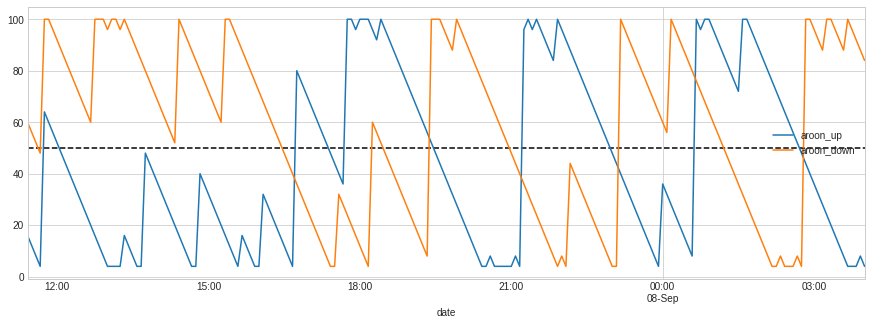

In [5]:
ax = data[['aroon_up', 'aroon_down']].iloc[-200:].plot(figsize=(15,5))
plt.hlines(y=50, xmin=data.iloc[-200:].index[0], xmax=data.iloc[-200:].index[-1], colors='k', linestyles="--")
plt.show()

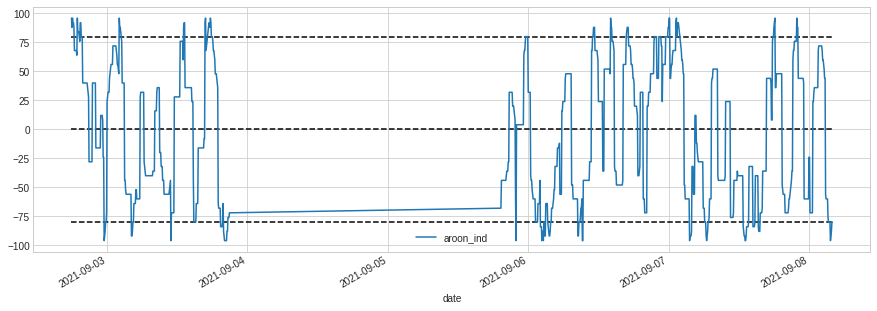

In [26]:
ax = data[['aroon_ind']].iloc[-1000:].plot(figsize=(15,5))
plt.hlines(y=0, xmin=data.iloc[-1000:].index[0], xmax=data.iloc[-1000:].index[-1], colors='k', linestyles="--")
plt.hlines(y=80, xmin=data.iloc[-1000:].index[0], xmax=data.iloc[-1000:].index[-1], colors='k', linestyles="--")
plt.hlines(y=-80, xmin=data.iloc[-1000:].index[0], xmax=data.iloc[-1000:].index[-1], colors='k', linestyles="--")
plt.show()

In [32]:
# aroon_ind > 0 --> long
# aroon_ind < 0 --> short
data['aroon_signal'] = np.where(data['aroon_ind'] > 80, 1,
                                np.where(data['aroon_ind'] < -80, -1, np.nan))
data['aroon_signal'] = data['aroon_signal'].ffill().fillna(0)

In [33]:
# aroon up > 50 and aroon down < 50 --> long
# aroon up < 50 and aroon down > 50 --> short
# else --> 0
# data['aroon_signal'] = np.where(np.all([data['aroon_up']>50, data['aroon_down']<50]), 1,
#                                 np.where(np.all([data['aroon_up']<50, data['aroon_down']>50]), -1, 0))

In [34]:
print(data['aroon_signal'].value_counts())
print("-"*50)
print(data['aroon_signal'].diff(1).apply(np.abs).value_counts())

 1.0    5352
-1.0    4624
Name: aroon_signal, dtype: int64
--------------------------------------------------
0.0    9852
2.0     123
Name: aroon_signal, dtype: int64


In [35]:
backtest = IterativeBacktester(data, data['aroon_signal'], freq='m5')

In [36]:
backtest.backtest()

  0%|          | 0/9975 [00:00<?, ?it/s]

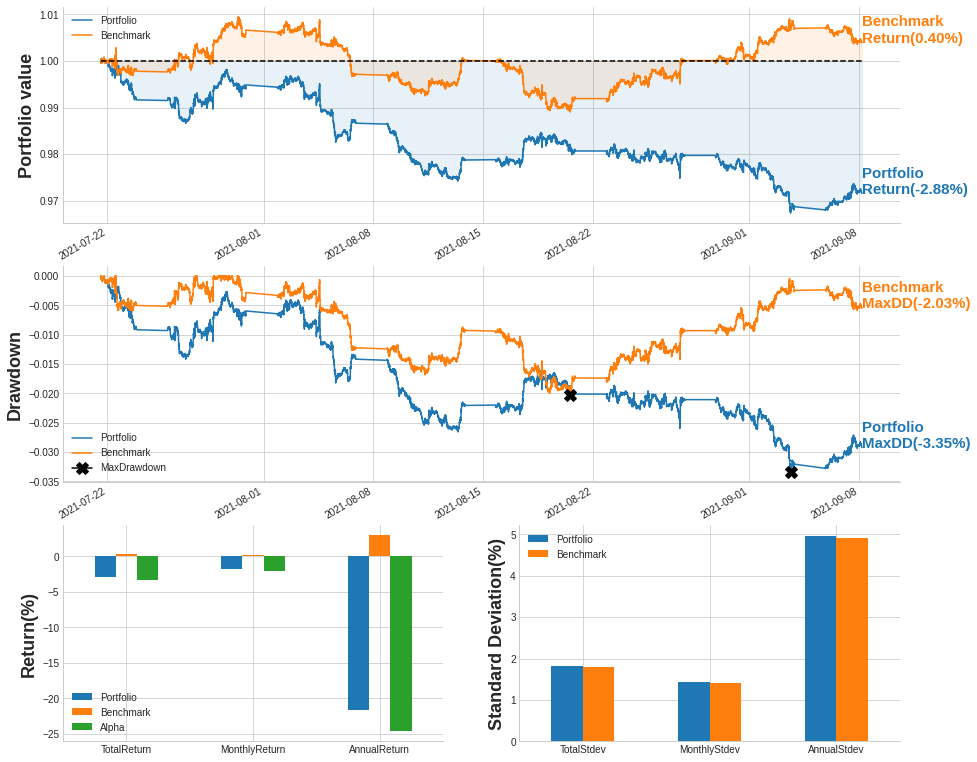

----------------------------------------------------------------------
Data length: |48 days 13:25:00|
Data range from |2021-07-21 14:35:00| to |2021-09-08 04:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -2.884 │       0.400 │  -3.285 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -1.782 │       0.247 │  -2.029 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │     -21.680 │       3.009 │ -24.689 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [37]:
backtest.results()